In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import svm, datasets
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#------------------------------------------------------------------------------
# 1- Split into a training set and a test set using a ShuffleSplit
#    + doing that in parallel for the differrent features to test
#------------------------------------------------------------------------------

from sklearn.model_selection import ShuffleSplit
def split_data(X, y, test_size=.25, train_size=None) :
    

    rs = ShuffleSplit(n_splits=1, test_size=test_size, train_size=train_size, random_state=0)
    for index_train, index_test in rs.split(y): pass

    X_train, X_test = {}, {}
    X_train, X_test = X[index_train, :], X[index_test, :]
    y_train, y_test =  y[index_train].copy(), y[index_test].copy()

    print('nb_trial_train : %s, nb_trial_test : %s'%(y_train.shape[0], y_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [3]:
 #------------------------------------------------------------------------------
# 4- Train a SVM classification model
#------------------------------------------------------------------------------

# When training an SVM with the Radial Basis Function (RBF) kernel,
#    two parameters must be considered: C and gamma.

#The parameter C, common to all SVM kernels, trades off misclassification
#of training examples against simplicity of the decision surface.
#    A low C makes the decision surface smooth,
#    while a high C aims at classifying all training examples correctly.

#gamma defines how much influence a single training example has.
#    The larger gamma is, the closer other examples must be to be affected.


from sklearn.grid_search import GridSearchCV # see http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.svm import SVC

def Train_SVM(X_train, y_train, size_c_gamma=32, ax=None, fig=None, plot=None) :


    C_range = np.logspace(-5, 10., size_c_gamma, base=2.)
    gamma_range = np.logspace(-14, 3, size_c_gamma, base=2.)

    

    '''param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': gamma_range, 'C': C_range},
                  {'kernel': ['linear'], 'C': C_range}]'''
    
    liste_kernel = ['rbf']#, 'poly', 'sigmoid']
    param_grid = [{'kernel': liste_kernel, 'gamma': gamma_range, 'C': C_range}]

    
    grid = GridSearchCV(SVC(verbose=False, tol=1e-3, max_iter = -1, ),
                        param_grid, verbose=1, scoring='f1_weighted', n_jobs=1,) #cv=50, 

    X_train_ = np.zeros((len(X_train), 0))
    X_train_ = np.hstack((X_train_, X_train))
    grid.fit(X_train, y_train.ravel())


    # plot the scores of the grid
    score_dict = grid.grid_scores_ # grid_scores_ contains parameter settings and scores
    
    scores_mean, scores_std ={}, {}
    for params, mean_score, scores in score_dict:
        try :
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)
        except:
            scores_mean[params['kernel']] = []
            scores_std[params['kernel']] = []
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)


    # draw heatmap of accuracy as a function of gamma and C
    '''fig1, ax1 = plt.subplots(1,4,figsize=(5*4,5))

    for x, k in enumerate(['rbf', 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax1[x].imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
        ax1[x].set_xlabel('gamma')
        ax1[x].set_ylabel('C')
        #ax.set_colorbar()
        ax1[x].set_title(k)
        fig1.colorbar(im, ax=ax1[x], pad=0.01, fraction=.047)
    
    scores = np.array(scores_mean['linear']) #.reshape((gamma_range.shape[0], C_range.shape[0]))
    #im = ax1.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
    
    ax1[-1].set_title('linear')
    ax1[-1].plot(C_range, scores, 'k')
    ax1[-1].set_xlabel('C')
    ax1[-1].set_ylabel('Score')
    
    fig1.tight_layout()
    plt.show()'''
    
    if plot is None :
        fig, ax = plt.subplots(1,1,figsize=(5,5))

    for x, k in enumerate(['rbf']): #, 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
        ax.set_xlabel('gamma')
        ax.set_ylabel('C')
        #ax.set_colorbar()
        ax.set_title(k)
        fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    if plot is None :
        fig.tight_layout()
        plt.show()
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    if plot is None :
        return grid
    else :
        return ax, fig, grid

/home/phantom/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/phantom/.local/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
#------------------------------------------------------------------------------
# 5- Quantitative evaluation of the model quality on the test set
#------------------------------------------------------------------------------
def Quantitative_evaluation(grid, X_test, classes, ax=None, fig=None, plot=None) :

    import itertools
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    
    y_pred = grid.predict(X_test)
    # see https://en.wikipedia.org/wiki/F1_score
    fone_score = np.array(metrics.f1_score(y_test, y_pred, average=None)).mean()
    
    print("Predicting the category names on the testing set")
    print('\nclassification_report on test \n', classification_report(y_test, y_pred, target_names=classes))
    
    
    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if plot is None :
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Reds)
    
    ax.set_title('Confusion matrix\n(fone_score on test => Accuracy = %0.2f)' % (fone_score))
    fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 'nb_trial = %s\n\n(%.0f %%)'%(cm[i, j], norm_cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        if i==j :
            ax.text(j, i+0.2, 'f1_score = %.2f'%(metrics.f1_score(y_test, y_pred, average=None)[i]),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    if plot is None :
        plt.tight_layout()
        plt.show()

        return y_pred
    else :
        return ax, fig, y_pred

In [5]:
from sklearn import metrics

def fig_final(X_train, y_train, X_test, y_test, var, classes) : #grid, y_pred, 
    
    #nb = int((X_train.shape[1]-1)*(X_train.shape[1]-(X_train.shape[1]/2)))
    #fig, ax = plt.subplots(1,nb,figsize=(10*(nb),10/1.68))
    #x = 0
    
    for x1 in range(X_train.shape[1]) :

        #nb = len(range(x1, X_train.shape[1]-1))
        #fig, axs = plt.subplots(3,nb,figsize=(10*(nb),3*10/1.68))
        
        x=0
        for x2 in range(x1, X_train.shape[1]) :
            if x2 != x1 :
                
                fig, ax = plt.subplots(1,3,figsize=(10*3,10))
        
                print('----------------------------------------------------\n%s-%s'%(var[x1], var[x2]))
                print('----------------------------------------------------')
                
                '''if nb==1: ax = axs
                else : ax =axs[:][x]'''
                
                X_fit = [[],[]]
                X_fit[0], X_fit[1] = X_train[:, x1], X_train[:, x2]
                X_fit = np.array(X_fit).transpose()
                
                X_t = [[],[]]
                X_t[0], X_t[1] = X_test[:, x1], X_test[:, x2]
                X_t = np.array(X_t).transpose()
                
                
                xlim = [min(X_train[:, x1]), max(X_train[:, x1])]
                ylim = [min(X_train[:, x2]), max(X_train[:, x2])]
                
                # create grid to evaluate model
                a = 1
                xx = np.linspace(xlim[0]-a, xlim[1]+a, len(X_train[:, x1]))
                yy = np.linspace(ylim[0]-a, ylim[1]+a, len(X_train[:, x2]))
                YY, XX = np.meshgrid(yy, xx)
                xy = np.vstack([XX.ravel(), YY.ravel()]).T

                ax[0], fig, grid = Train_SVM(X_fit, y_train, size_c_gamma=32, ax=ax[0], fig=fig, plot=True)
                ax[1], fig, y_pred = Quantitative_evaluation(grid, X_t, classes, ax=ax[1], fig=fig, plot=True)
                
                if grid.best_params_['kernel']!= 'linear' :
                    clf = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],
                              gamma=grid.best_params_['gamma'])
                else :
                    clf = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'])
                
                
                clf.fit(X_fit, y_train)
                Z = clf.decision_function(xy).reshape(XX.shape)



                # plot decision boundary and margins
                #ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
                ax[2].contourf(XX, YY, Z, cmap=plt.cm.RdGy, alpha=0.5)

                # plot support vectors
                ax[2].scatter(X_train[:, x1], X_train[:, x2], c=y_train, s=200, cmap=plt.cm.RdGy, alpha=0.3)
                #ax[x].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, linewidth=1, facecolors='none', edgecolors='k')

                #X_test_2d = X_test[:, x_:x_+2]:
                
                y_pred2 = clf.predict(X_t)

                print('%s-%s'%(var[x1], var[x2]), '\tscore grid :', clf.score(X_t, y_pred), '\tscore clf :',
                      clf.score(X_t, y_pred2))
                print('\t\tf1_score grid: \t%.2f'%np.array(metrics.f1_score(y_test, y_pred, average=None)).mean(),
                      '\tf1_score clf: %.2f'%np.array(metrics.f1_score(y_test, y_pred2, average=None)).mean(),
                      end='\n\n')


                ax[2].scatter(X_test[:, x1], X_test[:, x2], c=y_pred, s=40, cmap=plt.cm.RdGy)

                for a in range(len(y_test)) :
                    if y_test[a]!=y_pred[a] :
                        if y_test[a] == 1 : c='k'
                        else : c='r'
                        ax[2].scatter(X_test[a, x1], X_test[a, x2], facecolors='none', s=60, lw=2,
                                   edgecolors=c)

                ax[2].set_xlabel('%s'%var[x1])
                ax[2].set_ylabel('%s'%var[x2])
                x=x+1

            plt.show()

# Data

In [6]:
import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637',
        '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250',
        '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313',
        '2017-11-08_150410','2017-11-17_172706']
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

In [7]:
list_keys_param_fit = ['start_anti', 'tau', 'v_anti', 'latence', 'maxi']
X, y, var = [], [], []
a = 0
for x in range(len(sujet)) :

    print(sujet[x])
    print(Delete_list_trials[sujet[x]], Bad_Fit[sujet[x]])
    #-------------------------------------------------------------------------
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier :
        param_exp = pickle.load(fichier, encoding='latin1')
    A = ANEMO(param_exp)
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/goodness_of_fit_'+ sujet[x] +'.pkl')
    with open(file, 'rb') as fichier :
        goodness_of_fit = pickle.load(fichier, encoding='latin1')
    
    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier :
        param_fit = pickle.load(fichier, encoding='latin1')
    #-------------------------------------------------------------------------

    for block in range(N_blocks) :
        for trial in range(N_trials) :

            if trial in Delete_list_trials[sujet[x]][block] : y.append(1)
            elif trial in Bad_Fit[sujet[x]][block] : y.append(1)
            else : y.append(0)

            if a==0 :
                var.append('nb_nan')
                X.append([])
                var.append('residu')
                X.append([])
                '''for key in goodness_of_fit.keys() :
                    if key!='residual' :
                        var.append(key)
                        X.append([])'''
                for key in list_keys_param_fit :
                    var.append(key)
                    X.append([])
                a=1
            
            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)
            velocity_NAN = A.velocity_NAN(**arg)[0]

            
            nb_nan = [x for x in velocity_NAN[arg.StimulusOf-arg.t_0:] if str(x)=='nan']
            X[0].append(len(nb_nan)/len(velocity_NAN[arg.StimulusOf-arg.t_0:]))
            
            residu = (np.mean(abs(goodness_of_fit['residual'][block][trial][arg.StimulusOf-arg.t_0:])))
            
            if np.isnan(residu) :
                X[1].append(10)
            else :
                X[1].append(residu)
            
            
            k = 2
            '''for key in goodness_of_fit.keys() :
                if key!='residual' :
                    X[k].append(goodness_of_fit[key][block][trial])
                    k=k+1'''
    
            for key in param_fit.keys() :
                if key in list_keys_param_fit :
                    X[k].append(param_fit[key][block][trial])
                    k=k+1

AM
[[], [134], []] [[22], [], []]
BMC
[[76, 156], [57, 66, 71, 126, 128, 129, 137], [79, 137]] [[], [129], [79, 118, 123]]
CS
[[], [], [15, 95]] [[69, 141, 162], [35, 43, 44, 45, 47, 53, 58, 74, 119, 122, 123, 124, 127, 134, 135, 167], [5, 8, 14, 15, 25, 90, 95, 176, 178, 193]]
DC
[[101, 120, 185], [49, 66, 85, 127, 130, 144, 164], [31, 36]] [[3, 9, 34, 55, 57, 66], [7, 8, 10, 33, 123, 124, 192], [16, 17, 18, 20, 59, 73]]
FM
[[14, 29, 35, 48, 50, 58, 59, 60, 71, 73, 77, 80, 104, 157, 161, 167, 173, 174, 175, 178, 191, 198], [12, 31, 64, 68, 69, 70, 96, 98, 121, 129, 194], [100, 158, 177]] [[29, 73, 104], [12, 70, 76], [78, 79, 116]]
IP
[[], [182], []] [[], [], []]
LB
[[10, 42, 82, 83, 90, 143, 150, 151, 163, 179], [72, 116, 118, 123, 162, 164, 178], [5, 11, 21, 32, 44, 53, 98]] [[29, 36, 50, 52, 94, 100, 163, 170, 176, 190, 196, 198], [68, 72, 85, 91, 92, 132, 133, 135, 150, 155, 188], [52, 95, 113, 146, 154, 163]]
OP
[[28, 32, 38, 40, 46, 52, 68, 70, 71, 76, 81, 85, 86, 89, 90, 98, 12

In [8]:
classes = ['good', 'Bad']

X1 = np.array(X)
y1 = np.array(y)
X1 = X1.transpose()
print(X1.shape)

(7200, 7)


In [9]:
X_train, X_test, y_train, y_test = split_data(X1, y1, test_size=.7, train_size=None)
print(y_train[y_train>0])

nb_trial_train : 2160, nb_trial_test : 5040
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


----------------------------------------------------
nb_nan-residu
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  1.6min finished


The best parameters are {'C': 97.87735607267012, 'gamma': 3.740486195263386, 'kernel': 'rbf'} with a score of 0.91
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.99      0.96      4609
        Bad       0.80      0.24      0.37       431

avg / total       0.92      0.93      0.91      5040

nb_nan-residu 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.67 	f1_score clf: 0.67



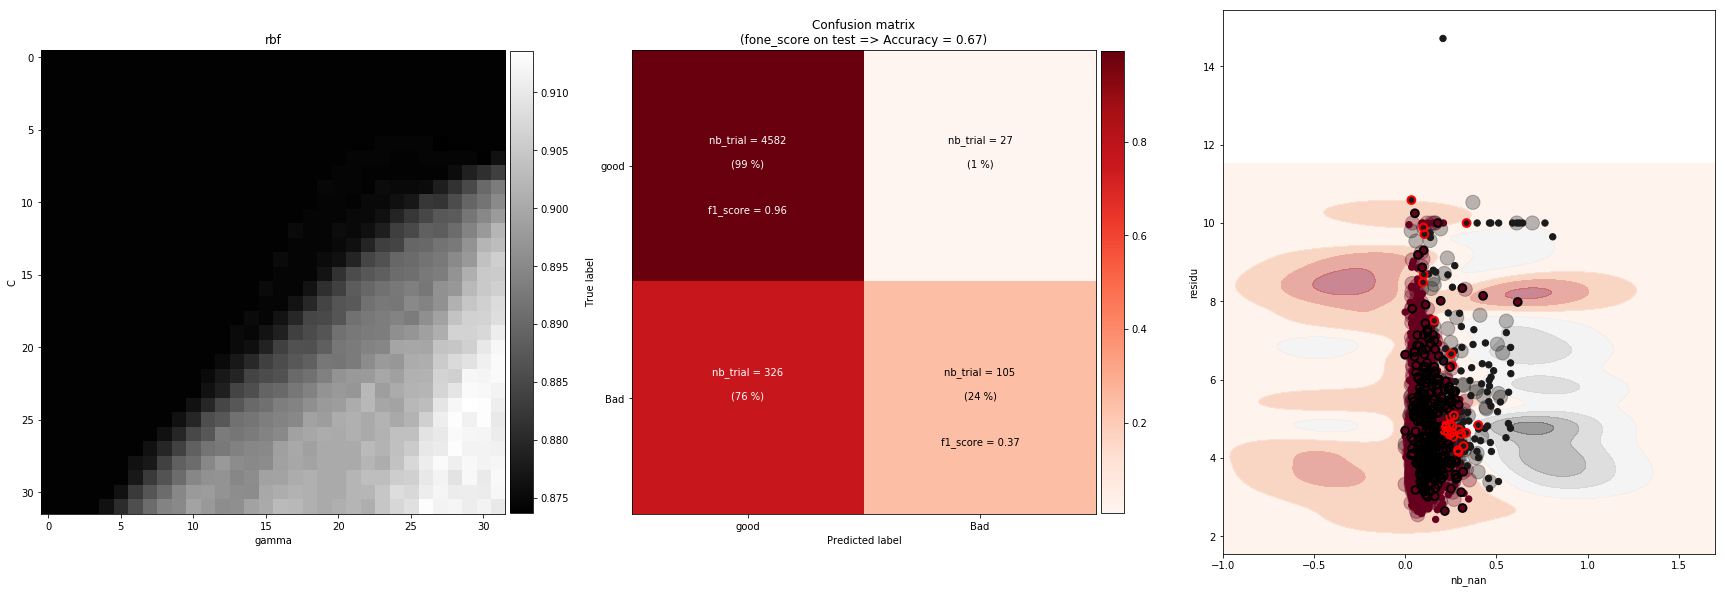

----------------------------------------------------
nb_nan-start_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.0min finished


The best parameters are {'C': 1024.0, 'gamma': 0.005841866727922688, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.99      0.96      4609
        Bad       0.62      0.14      0.23       431

avg / total       0.90      0.92      0.90      5040

nb_nan-start_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.60 	f1_score clf: 0.60



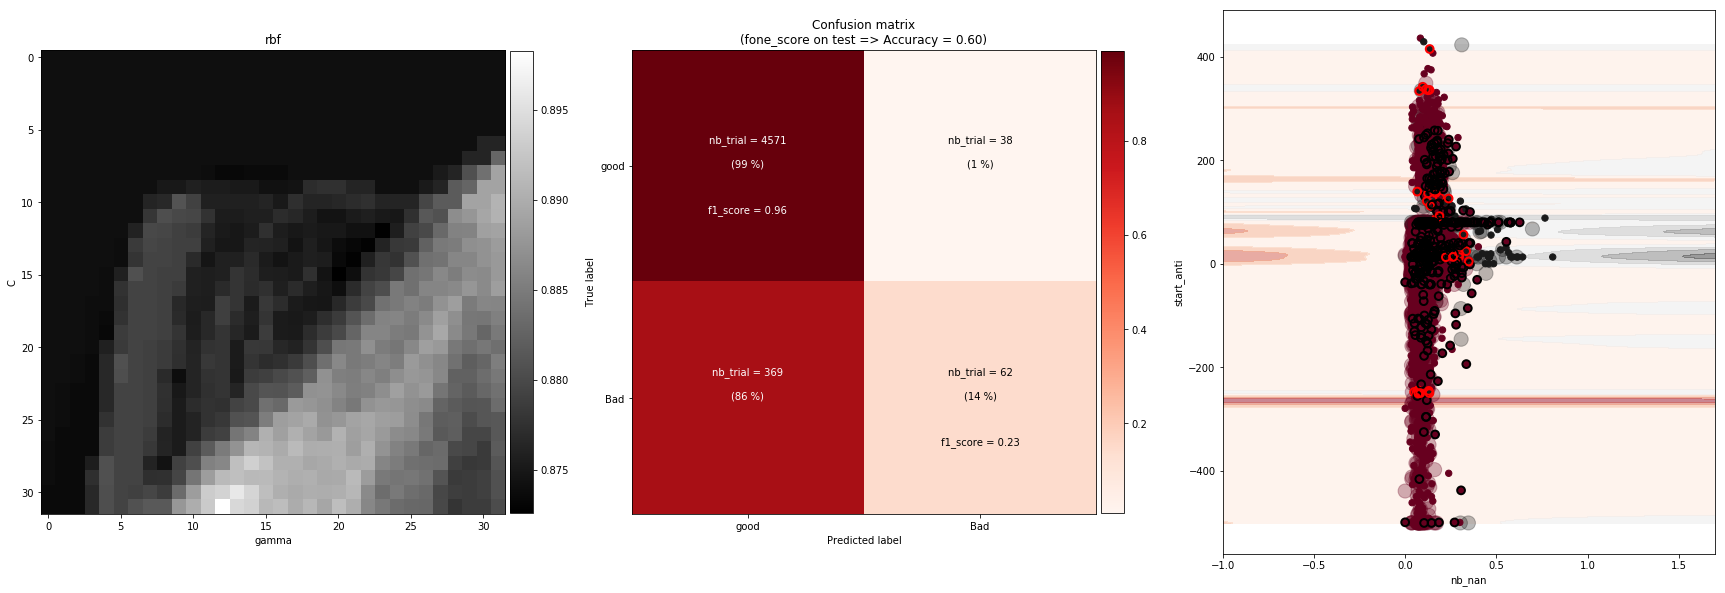

----------------------------------------------------
nb_nan-tau
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  2.8min finished


The best parameters are {'C': 1024.0, 'gamma': 0.008543436787176647, 'kernel': 'rbf'} with a score of 0.91
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      1.00      0.96      4609
        Bad       0.84      0.21      0.34       431

avg / total       0.92      0.93      0.91      5040

nb_nan-tau 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.65 	f1_score clf: 0.65



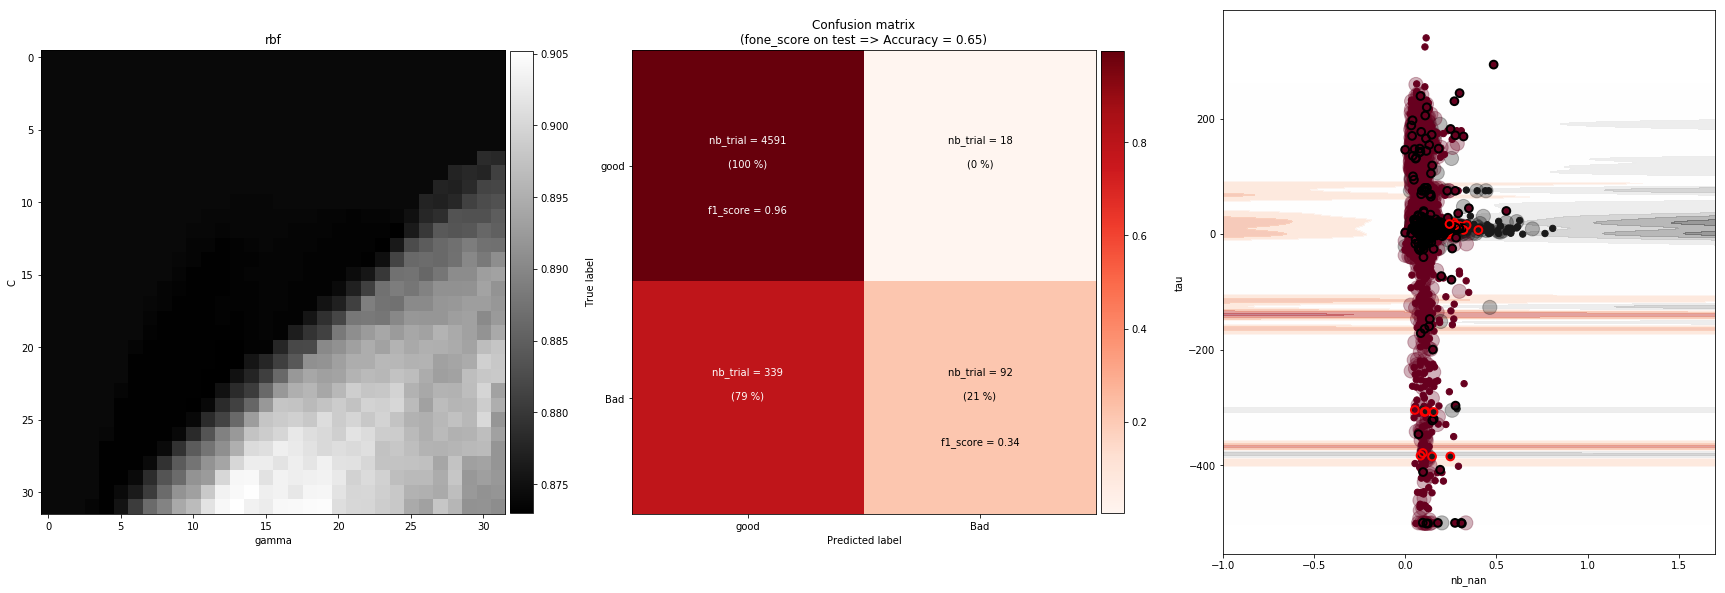

----------------------------------------------------
nb_nan-v_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.9min finished


The best parameters are {'C': 1024.0, 'gamma': 0.003994575920317453, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.96      4609
        Bad       0.54      0.10      0.17       431

avg / total       0.89      0.92      0.89      5040

nb_nan-v_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.56 	f1_score clf: 0.56



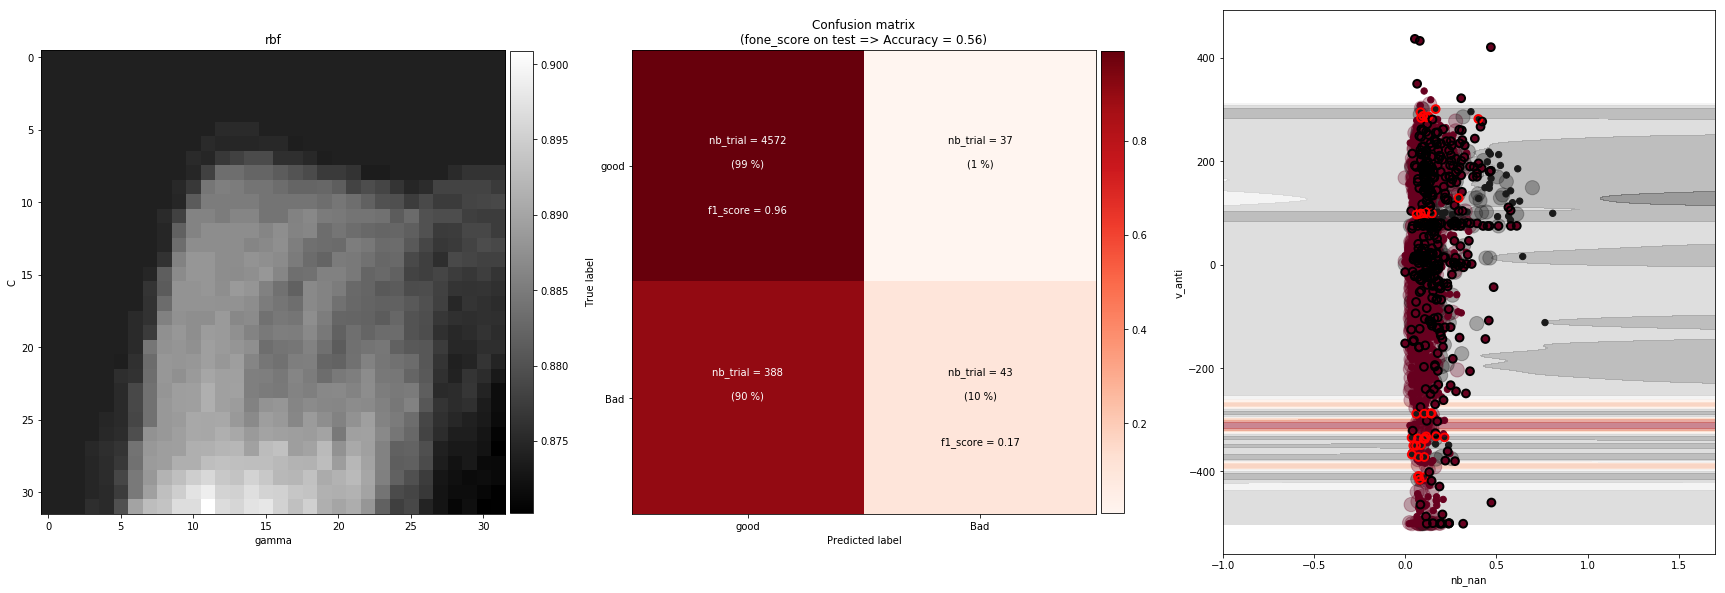

----------------------------------------------------
nb_nan-latence
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.2min finished


The best parameters are {'C': 523.5770550278497, 'gamma': 0.38233342215886723, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.97      0.95      4609
        Bad       0.43      0.27      0.33       431

avg / total       0.89      0.91      0.90      5040

nb_nan-latence 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.64 	f1_score clf: 0.64



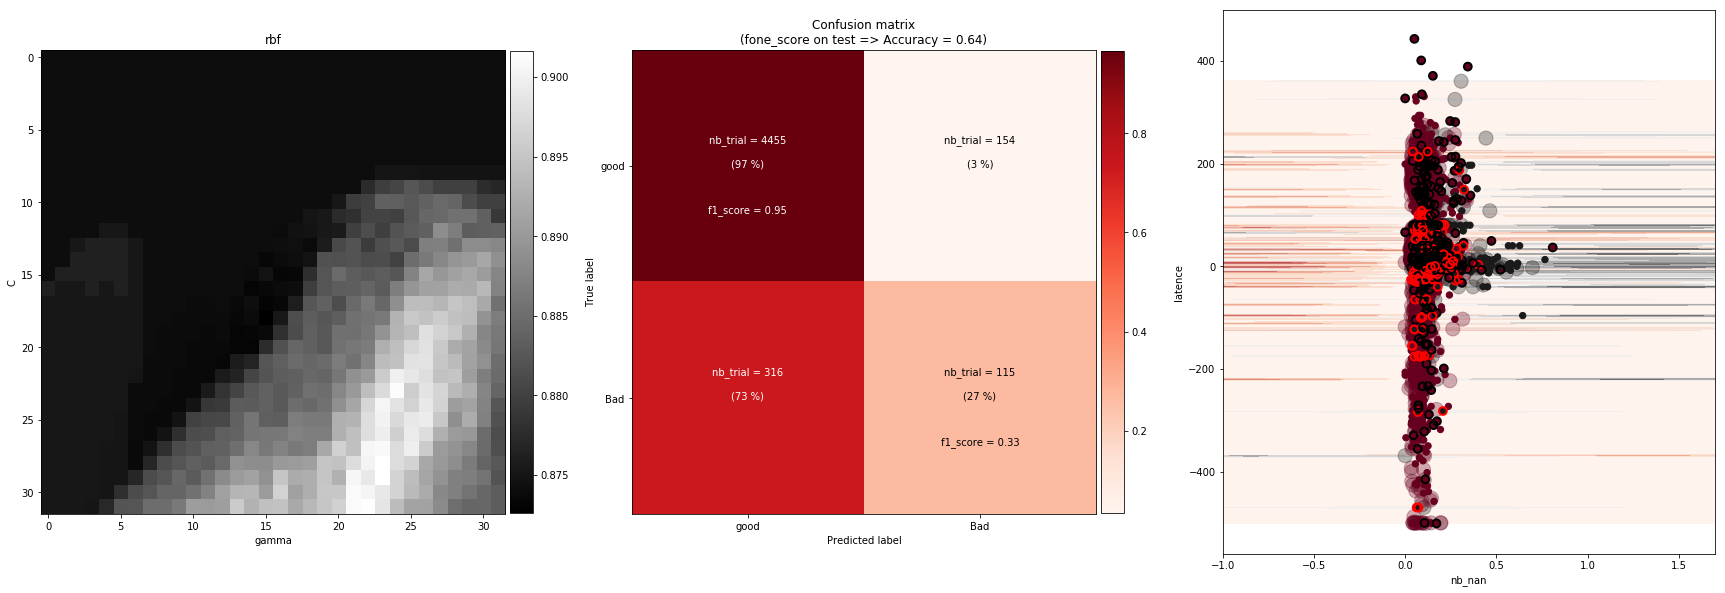

----------------------------------------------------
nb_nan-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  5.7min finished


The best parameters are {'C': 1024.0, 'gamma': 0.03908017248795583, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.95      4609
        Bad       0.50      0.17      0.26       431

avg / total       0.89      0.91      0.89      5040

nb_nan-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.60 	f1_score clf: 0.60



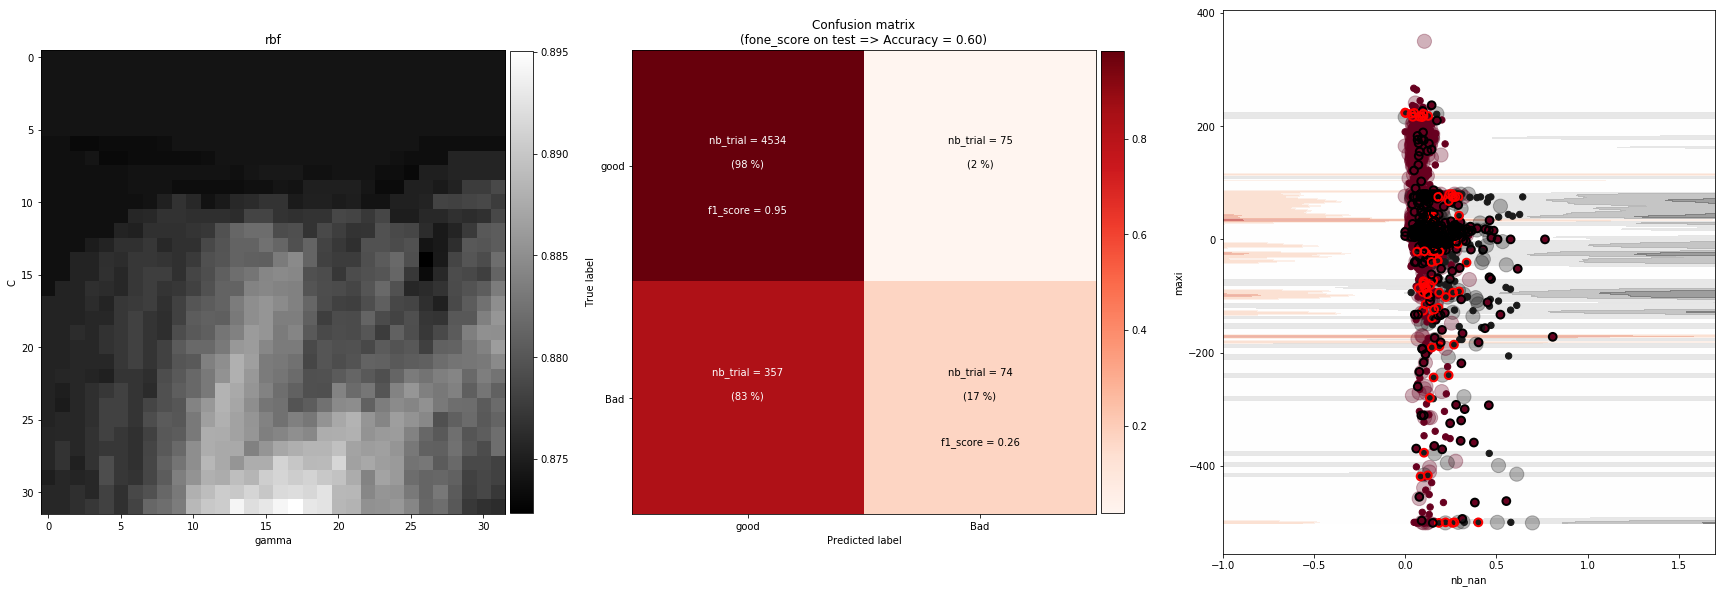

----------------------------------------------------
residu-start_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.0min finished


The best parameters are {'C': 0.8942249331776565, 'gamma': 0.12223606704192902, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      1.00      0.96      4609
        Bad       0.79      0.11      0.20       431

avg / total       0.91      0.92      0.89      5040

residu-start_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.58 	f1_score clf: 0.58



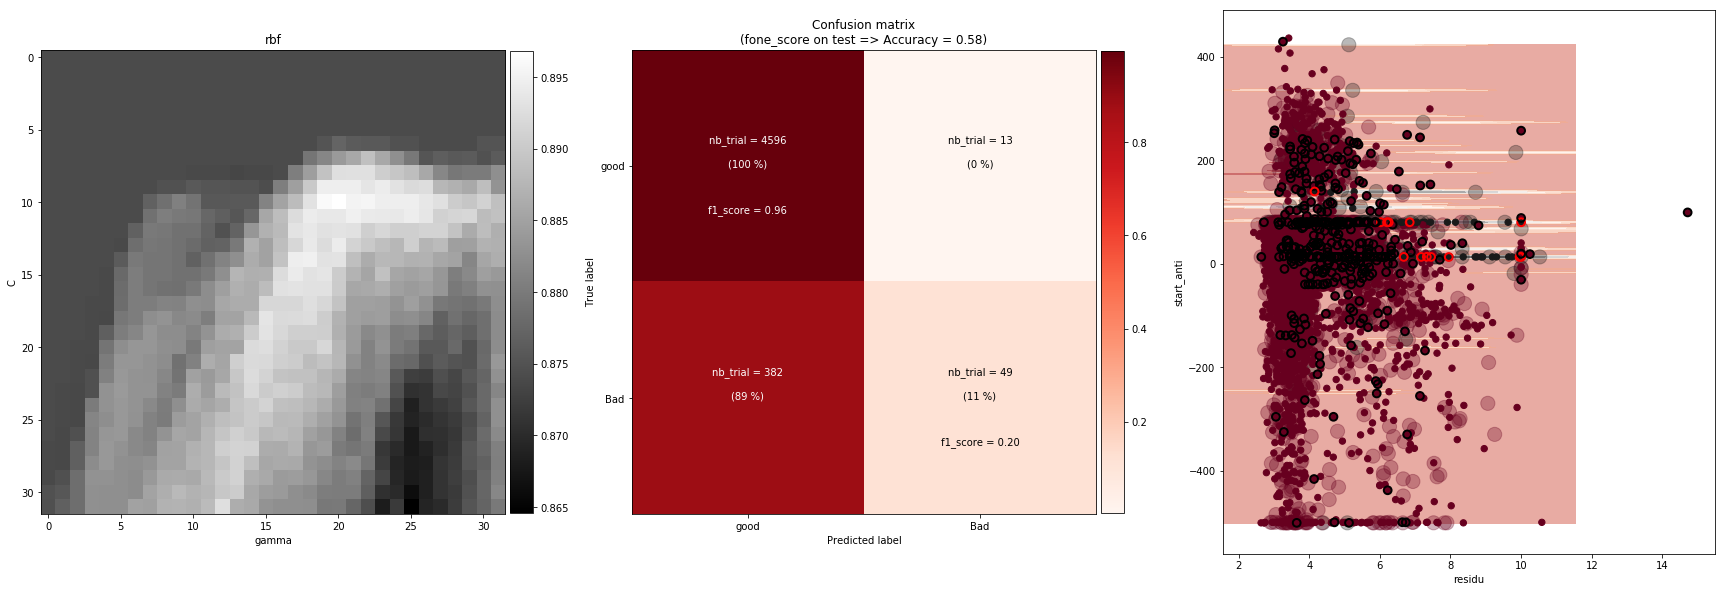

----------------------------------------------------
residu-tau
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.2min finished


The best parameters are {'C': 3.4204675622294167, 'gamma': 0.8177191994837885, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.95      4609
        Bad       0.43      0.08      0.14       431

avg / total       0.88      0.91      0.88      5040

residu-tau 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.55 	f1_score clf: 0.55



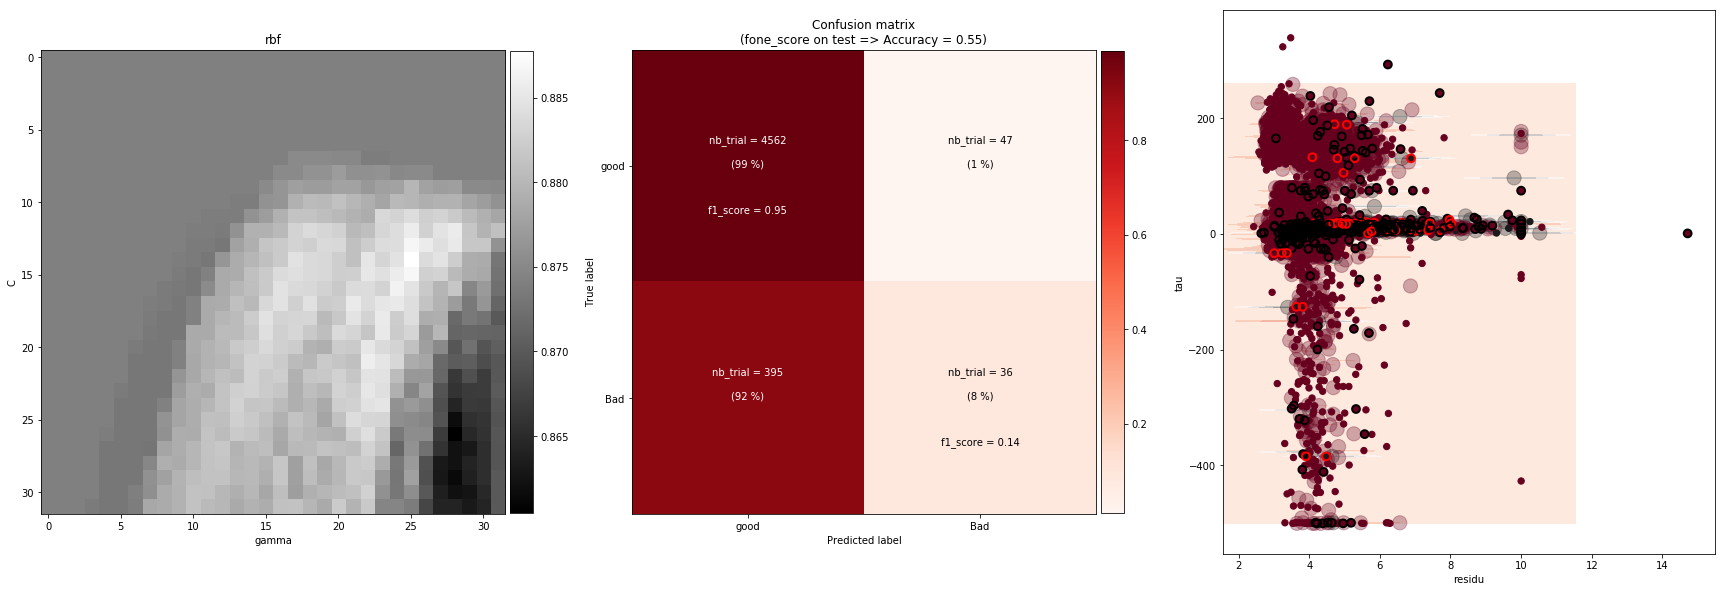

----------------------------------------------------
residu-v_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.9min finished


The best parameters are {'C': 69.98783416055109, 'gamma': 0.0012771084652837615, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.99      0.96      4609
        Bad       0.66      0.15      0.24       431

avg / total       0.90      0.92      0.90      5040

residu-v_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.60 	f1_score clf: 0.60



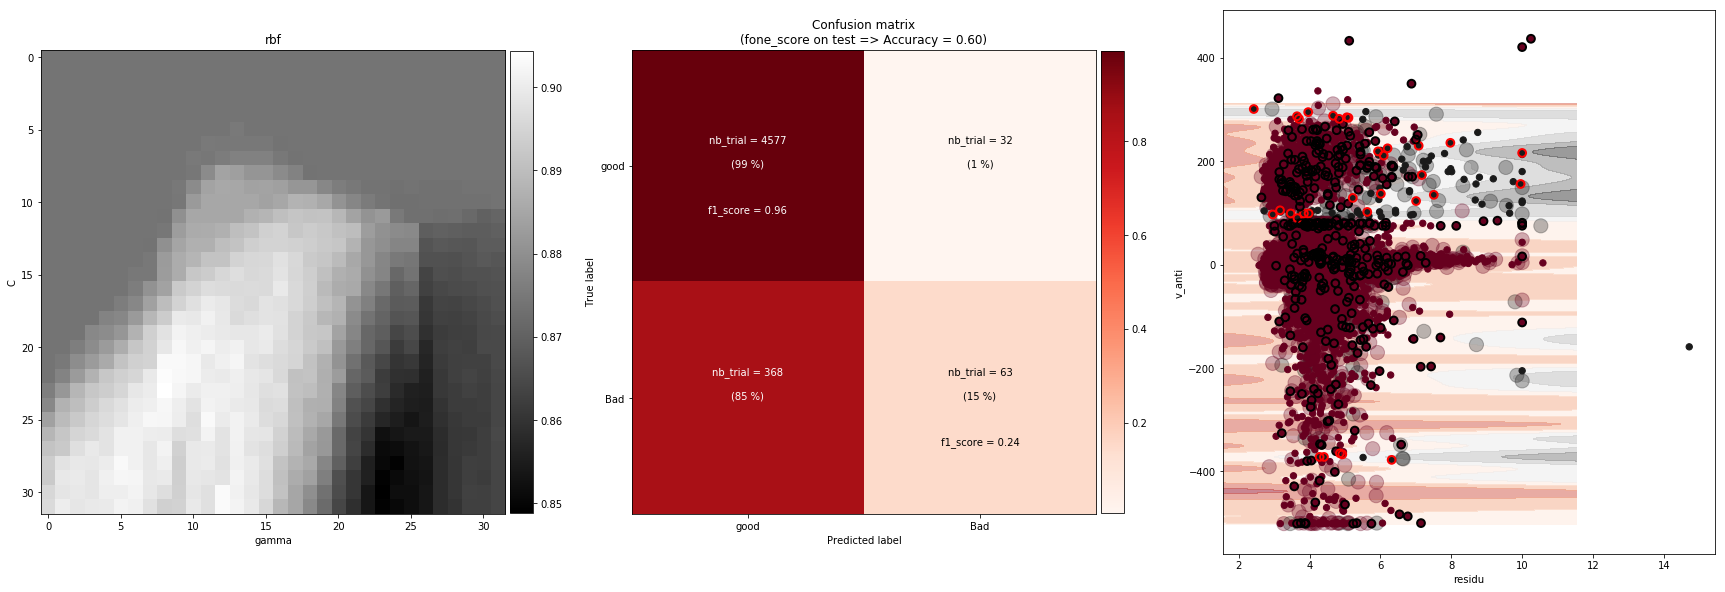

----------------------------------------------------
residu-latence
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.4min finished


The best parameters are {'C': 6.689672036022699, 'gamma': 0.03908017248795583, 'kernel': 'rbf'} with a score of 0.91
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.96      4609
        Bad       0.55      0.13      0.21       431

avg / total       0.89      0.92      0.89      5040

residu-latence 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.58 	f1_score clf: 0.58



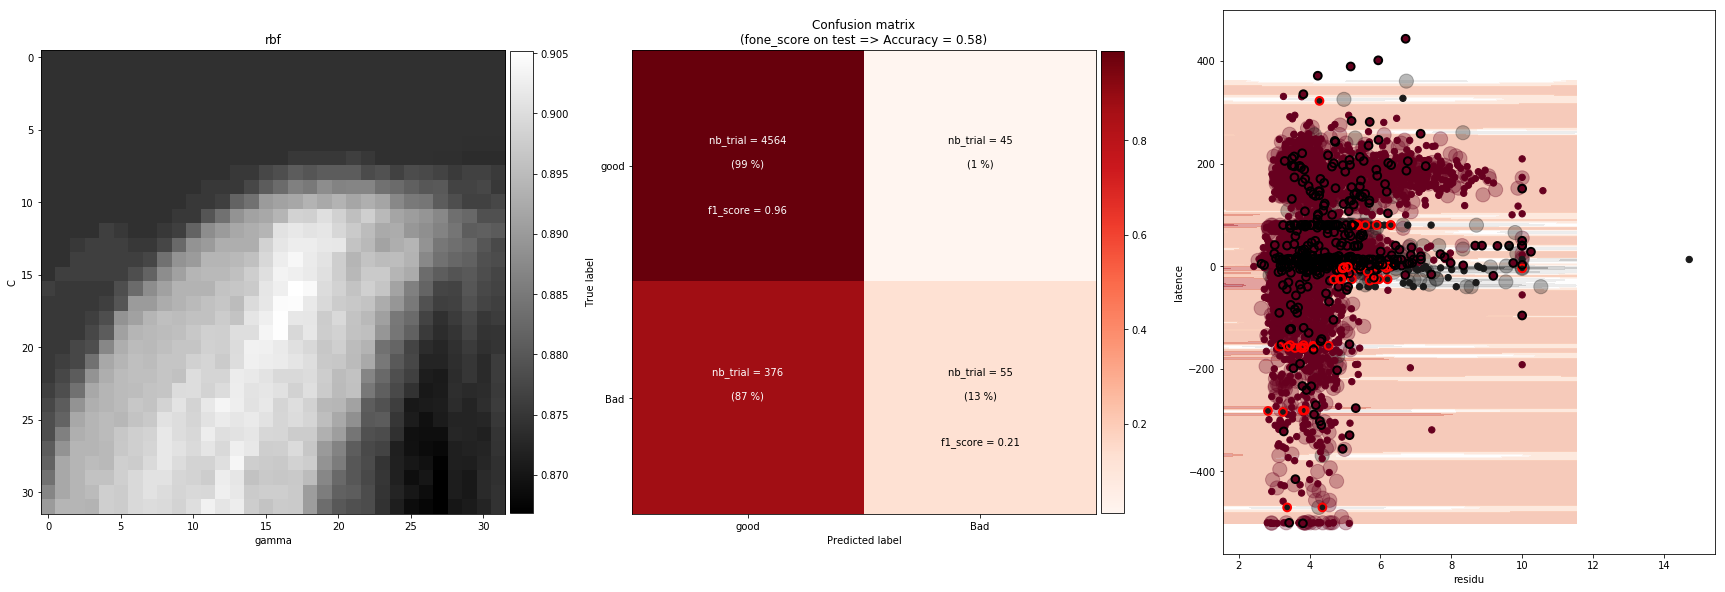

----------------------------------------------------
residu-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  5.4min finished


The best parameters are {'C': 136.88060141709667, 'gamma': 0.008543436787176647, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.95      4609
        Bad       0.48      0.18      0.26       431

avg / total       0.89      0.91      0.89      5040

residu-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.61 	f1_score clf: 0.61



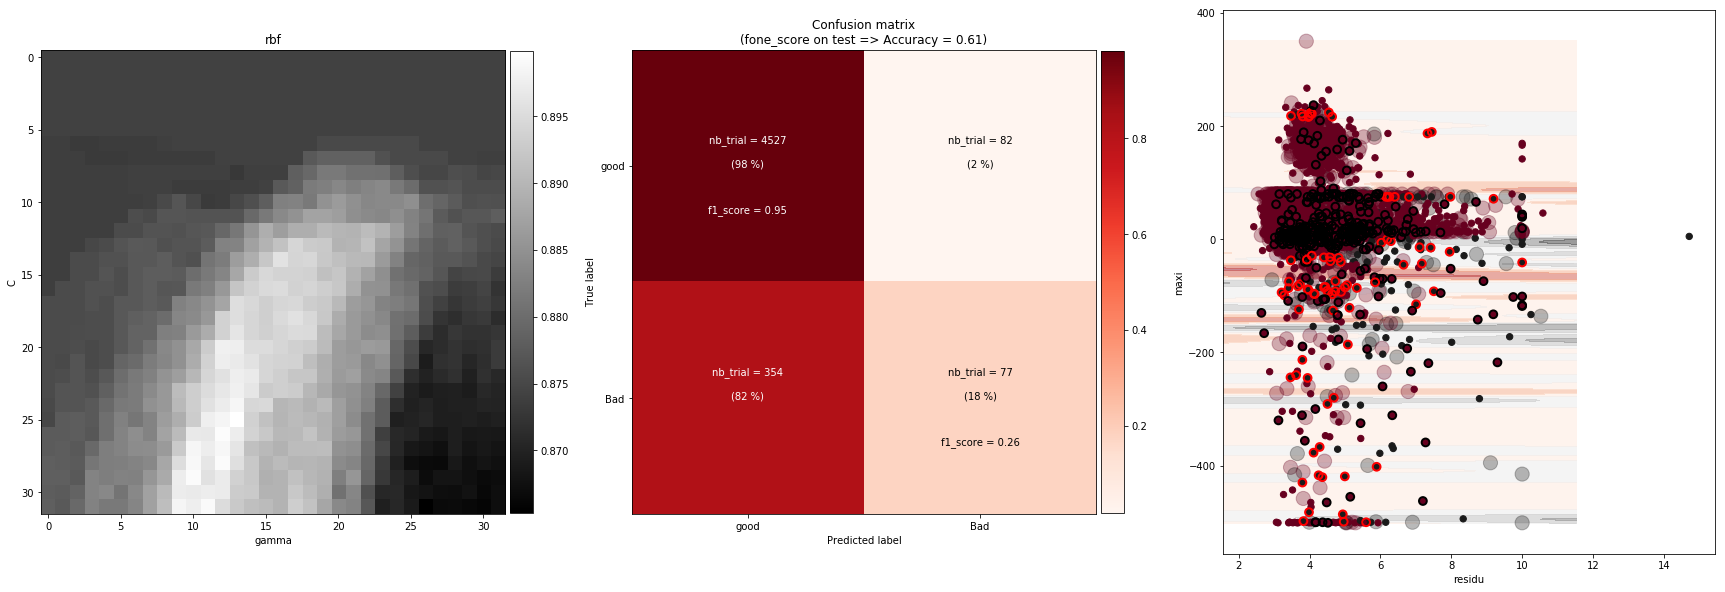

----------------------------------------------------
start_anti-tau
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  6.4min finished


The best parameters are {'C': 25.588423395730693, 'gamma': 2.5576852026530355, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.98      0.95      4609
        Bad       0.33      0.13      0.18       431

avg / total       0.87      0.90      0.88      5040

start_anti-tau 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.57 	f1_score clf: 0.57



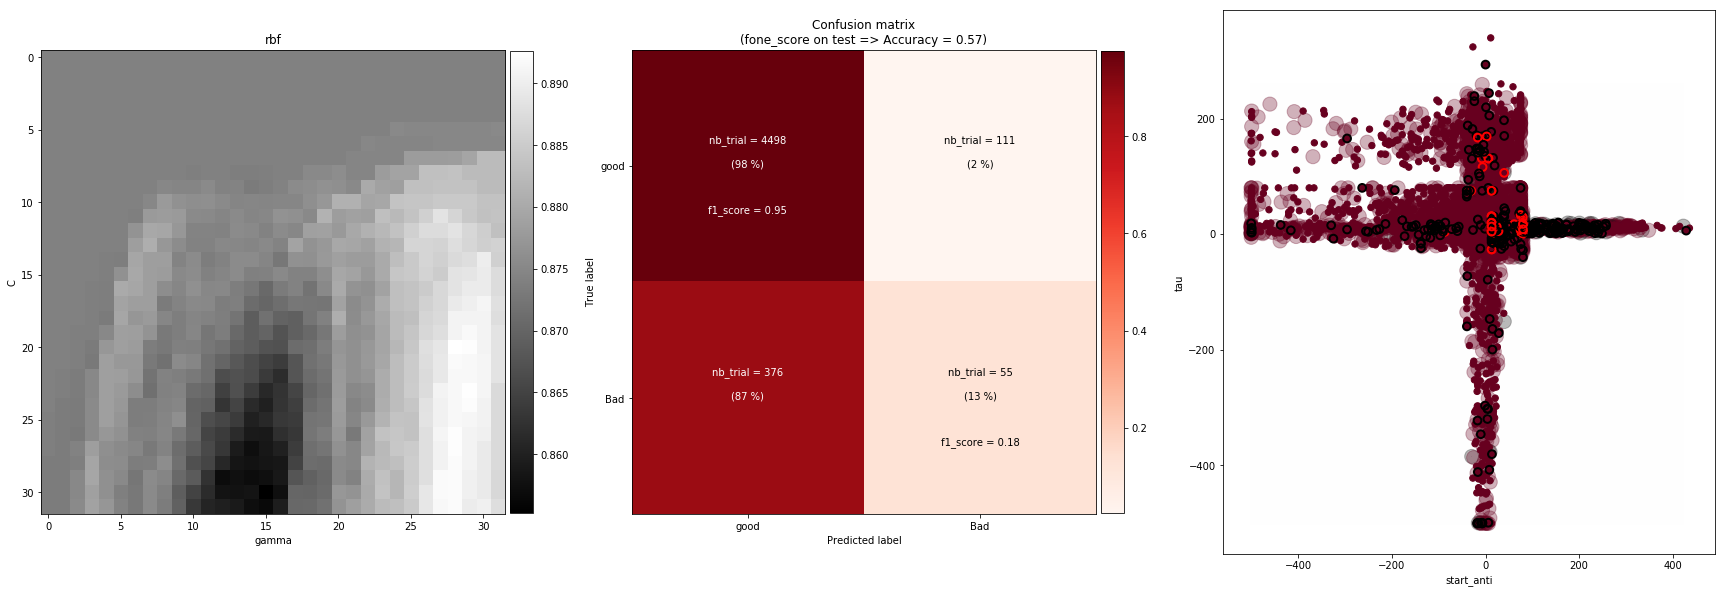

----------------------------------------------------
start_anti-v_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.5min finished


The best parameters are {'C': 2.4458273711349374, 'gamma': 0.001867707010734873, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.95      4609
        Bad       0.49      0.08      0.14       431

avg / total       0.88      0.91      0.89      5040

start_anti-v_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.55 	f1_score clf: 0.55



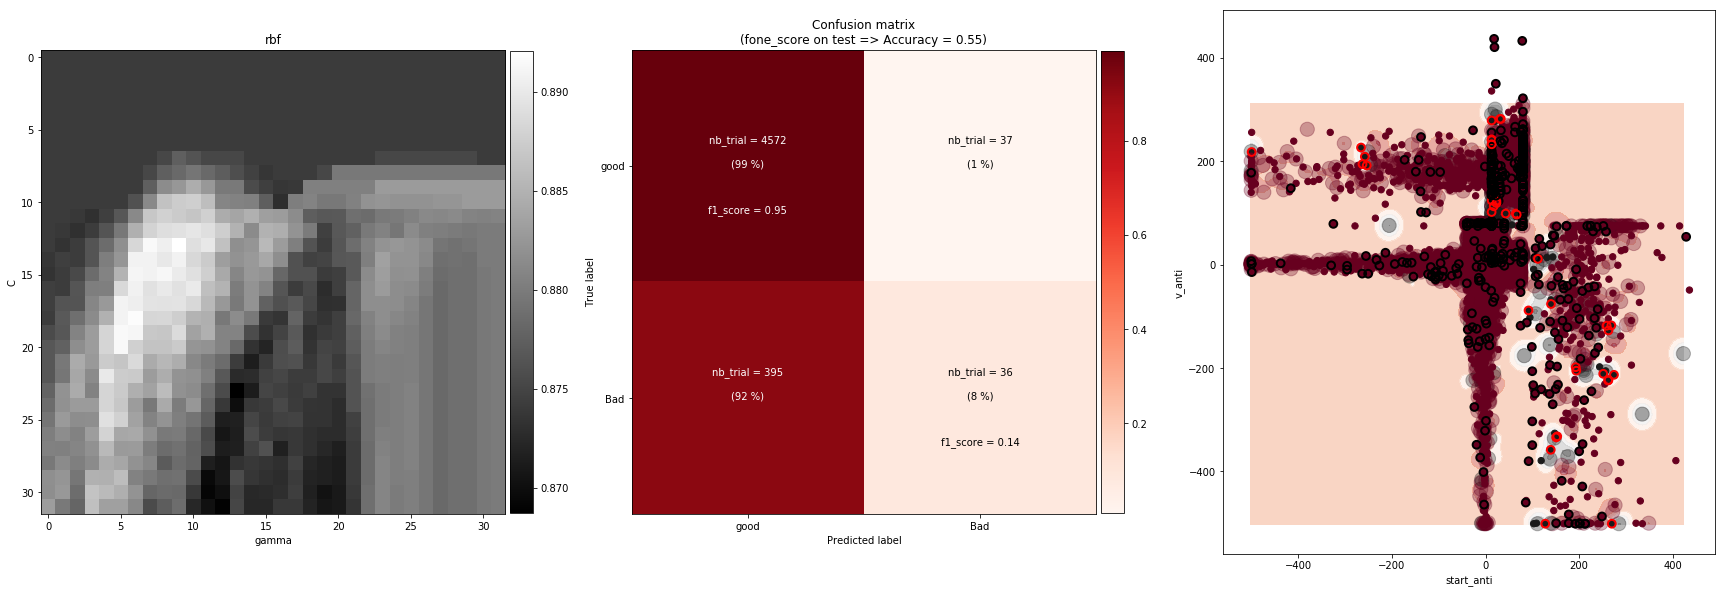

----------------------------------------------------
start_anti-latence
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.5min finished


The best parameters are {'C': 1.7489046221194973, 'gamma': 0.018272355712463845, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.95      4609
        Bad       0.45      0.13      0.20       431

avg / total       0.88      0.91      0.89      5040

start_anti-latence 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.58 	f1_score clf: 0.58



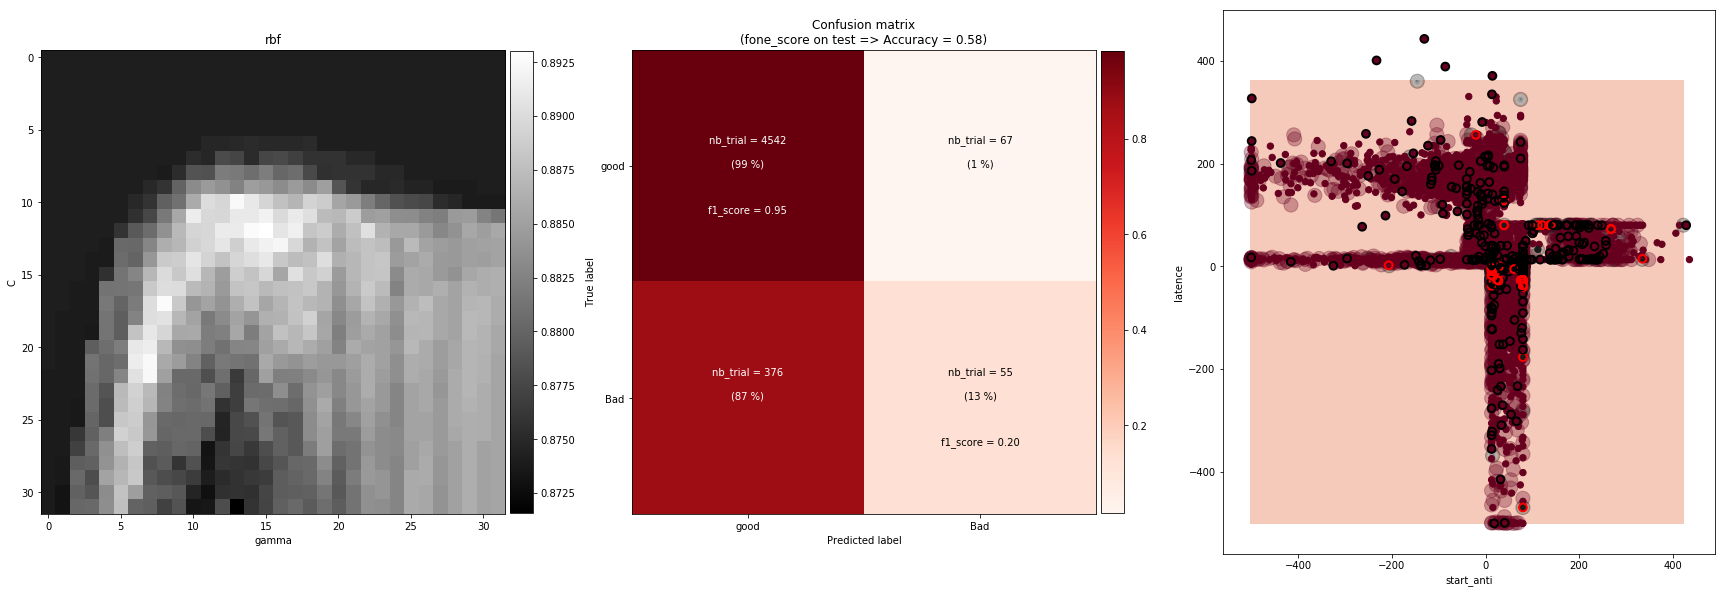

----------------------------------------------------
start_anti-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.6min finished


The best parameters are {'C': 732.2177984374031, 'gamma': 0.0004083051779799011, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.95      4609
        Bad       0.47      0.19      0.27       431

avg / total       0.89      0.91      0.89      5040

start_anti-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.61 	f1_score clf: 0.61



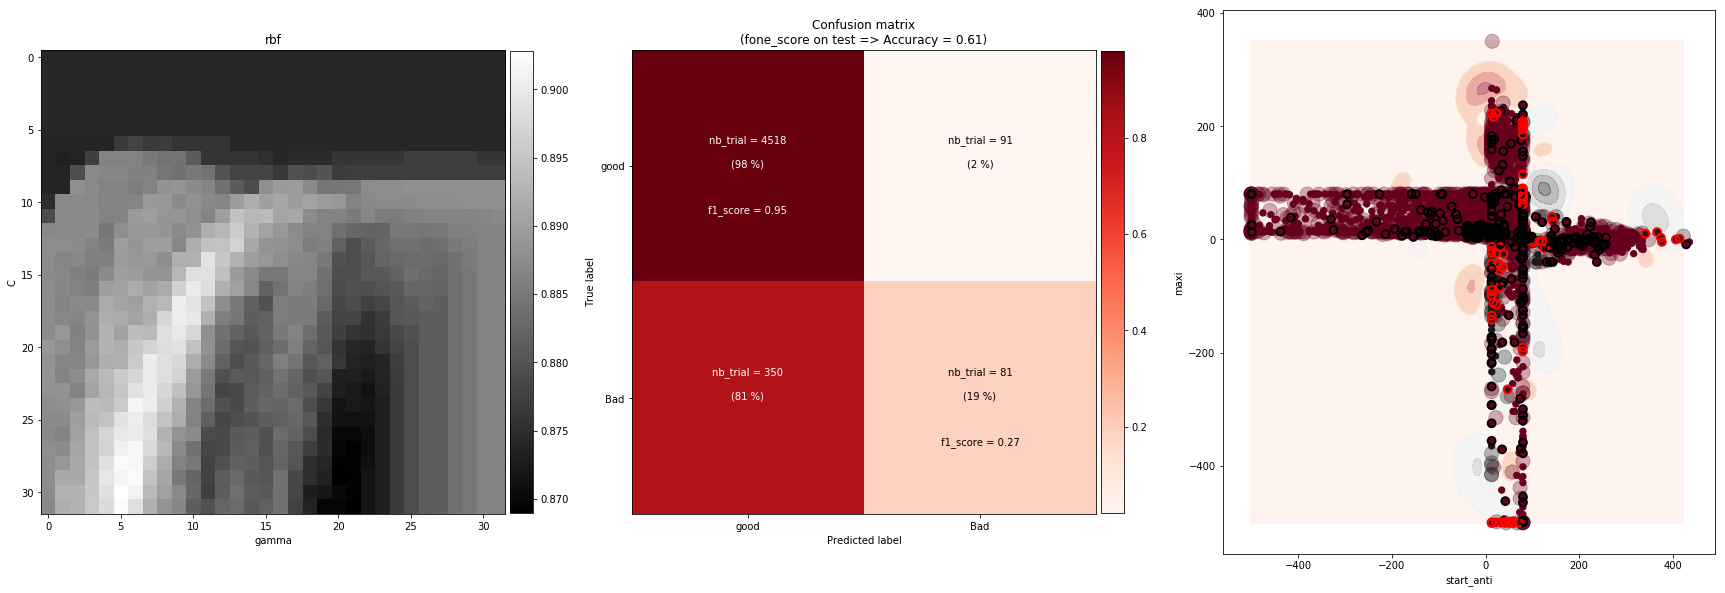

----------------------------------------------------
tau-v_anti
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.6min finished


The best parameters are {'C': 2.4458273711349374, 'gamma': 0.018272355712463845, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.98      0.95      4609
        Bad       0.34      0.13      0.18       431

avg / total       0.87      0.90      0.88      5040

tau-v_anti 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.57 	f1_score clf: 0.57



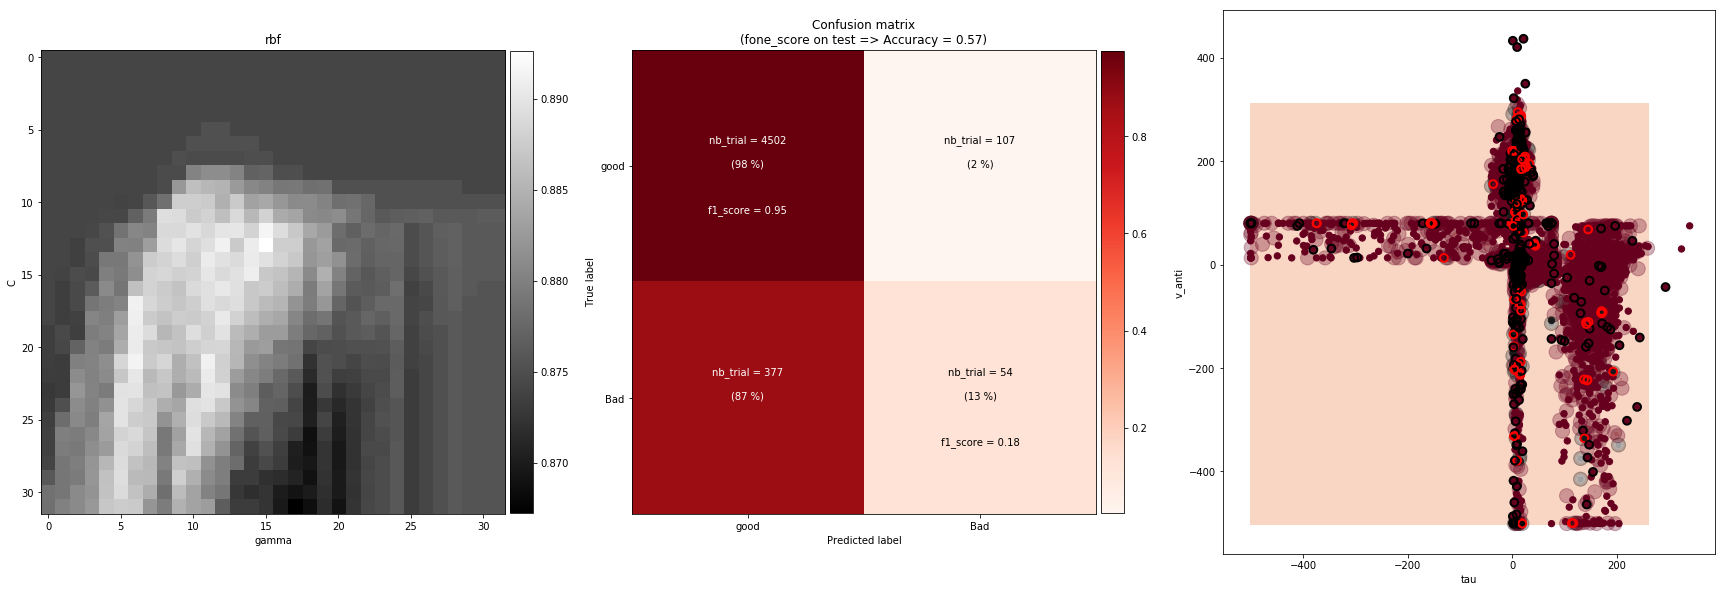

----------------------------------------------------
tau-latence
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  5.4min finished


The best parameters are {'C': 1.7489046221194973, 'gamma': 0.05715279016670322, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.98      0.95      4609
        Bad       0.42      0.12      0.19       431

avg / total       0.88      0.91      0.89      5040

tau-latence 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.57 	f1_score clf: 0.57



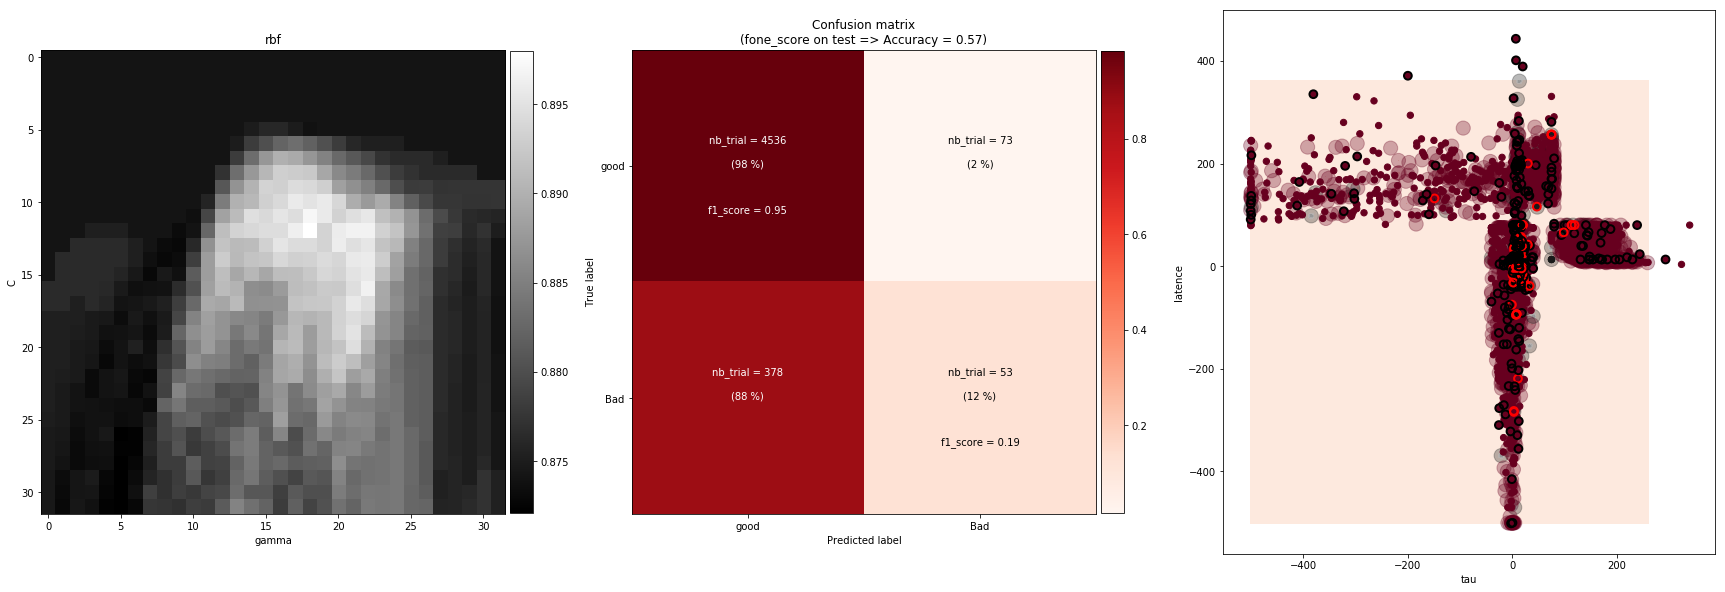

----------------------------------------------------
tau-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  4.7min finished


The best parameters are {'C': 50.04525180316483, 'gamma': 0.003994575920317453, 'kernel': 'rbf'} with a score of 0.89
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.96      4609
        Bad       0.54      0.19      0.28       431

avg / total       0.90      0.92      0.90      5040

tau-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.62 	f1_score clf: 0.62



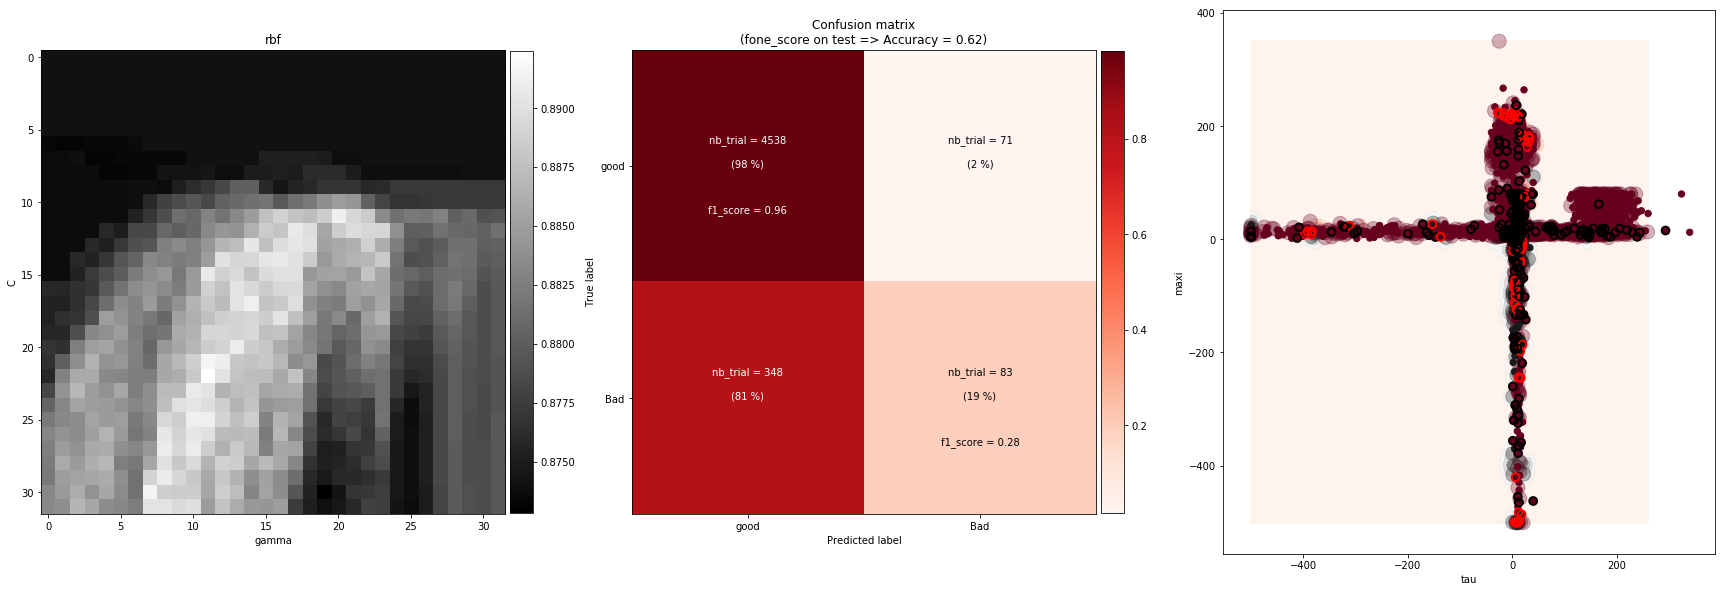

----------------------------------------------------
v_anti-latence
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.3min finished


The best parameters are {'C': 25.588423395730693, 'gamma': 0.0002791926122353385, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.92      0.99      0.96      4609
        Bad       0.53      0.12      0.20       431

avg / total       0.89      0.92      0.89      5040

v_anti-latence 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.58 	f1_score clf: 0.58



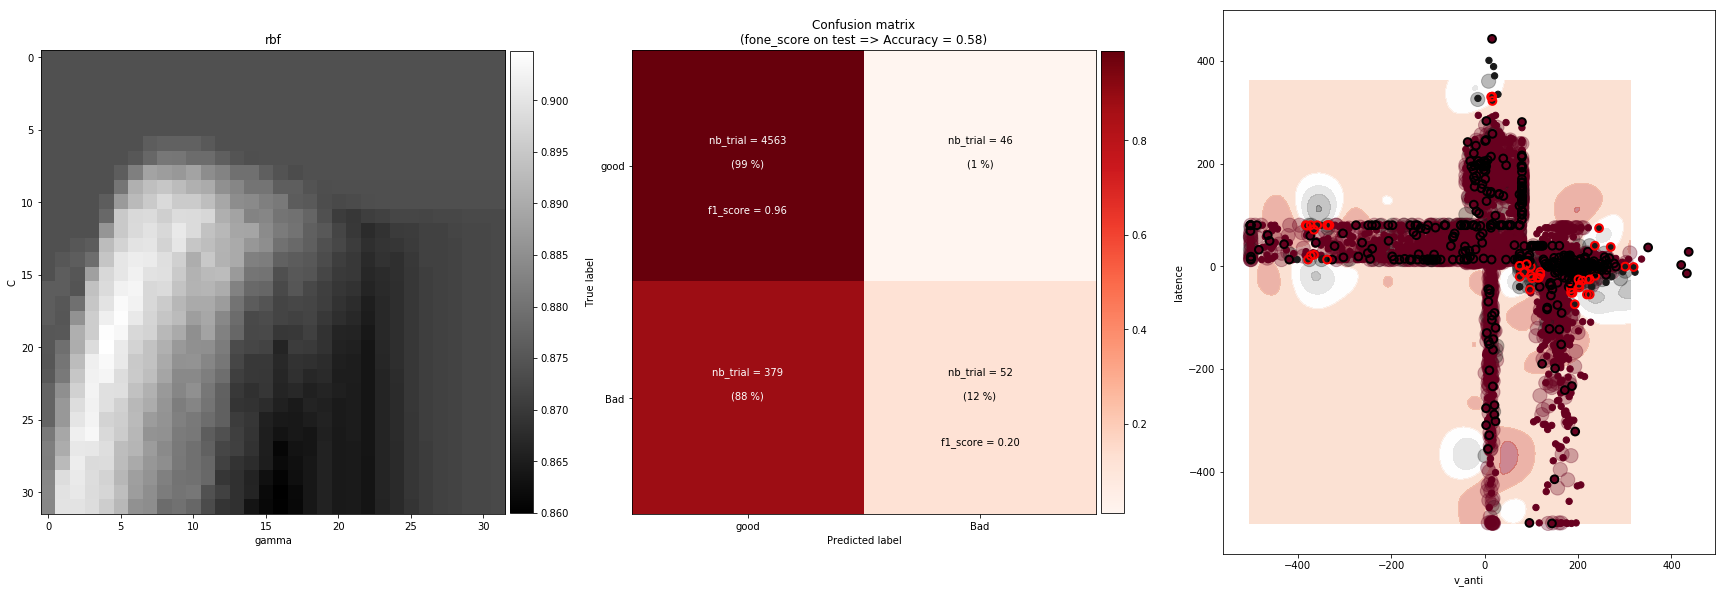

----------------------------------------------------
v_anti-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.9min finished


The best parameters are {'C': 1024.0, 'gamma': 0.0005971258230309898, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.95      4609
        Bad       0.39      0.17      0.23       431

avg / total       0.88      0.91      0.89      5040

v_anti-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.59 	f1_score clf: 0.59



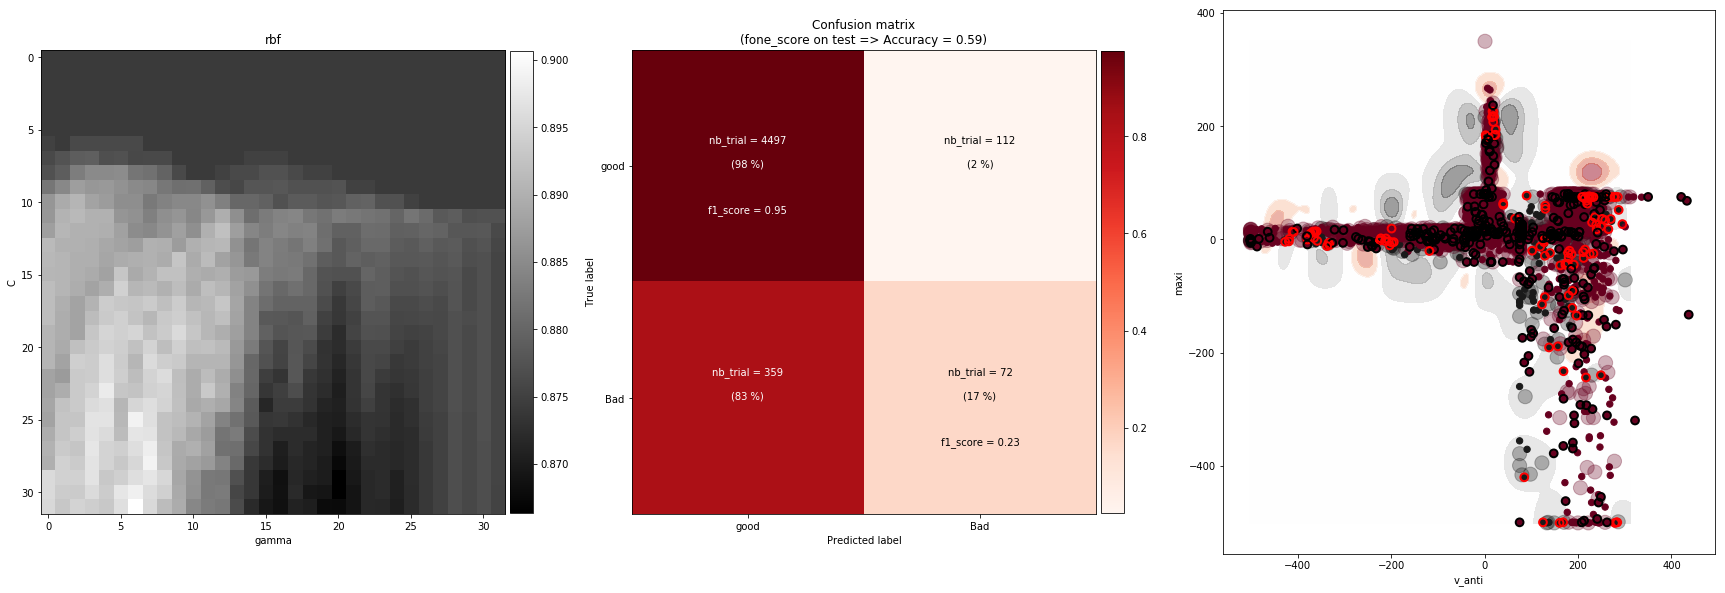

----------------------------------------------------
latence-maxi
----------------------------------------------------
Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


[Parallel(n_jobs=1)]: Done 3072 out of 3072 | elapsed:  3.8min finished


The best parameters are {'C': 97.87735607267012, 'gamma': 0.0005971258230309898, 'kernel': 'rbf'} with a score of 0.90
Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.93      0.98      0.95      4609
        Bad       0.42      0.17      0.24       431

avg / total       0.88      0.91      0.89      5040

latence-maxi 	score grid : 1.0 	score clf : 1.0
		f1_score grid: 	0.60 	f1_score clf: 0.60



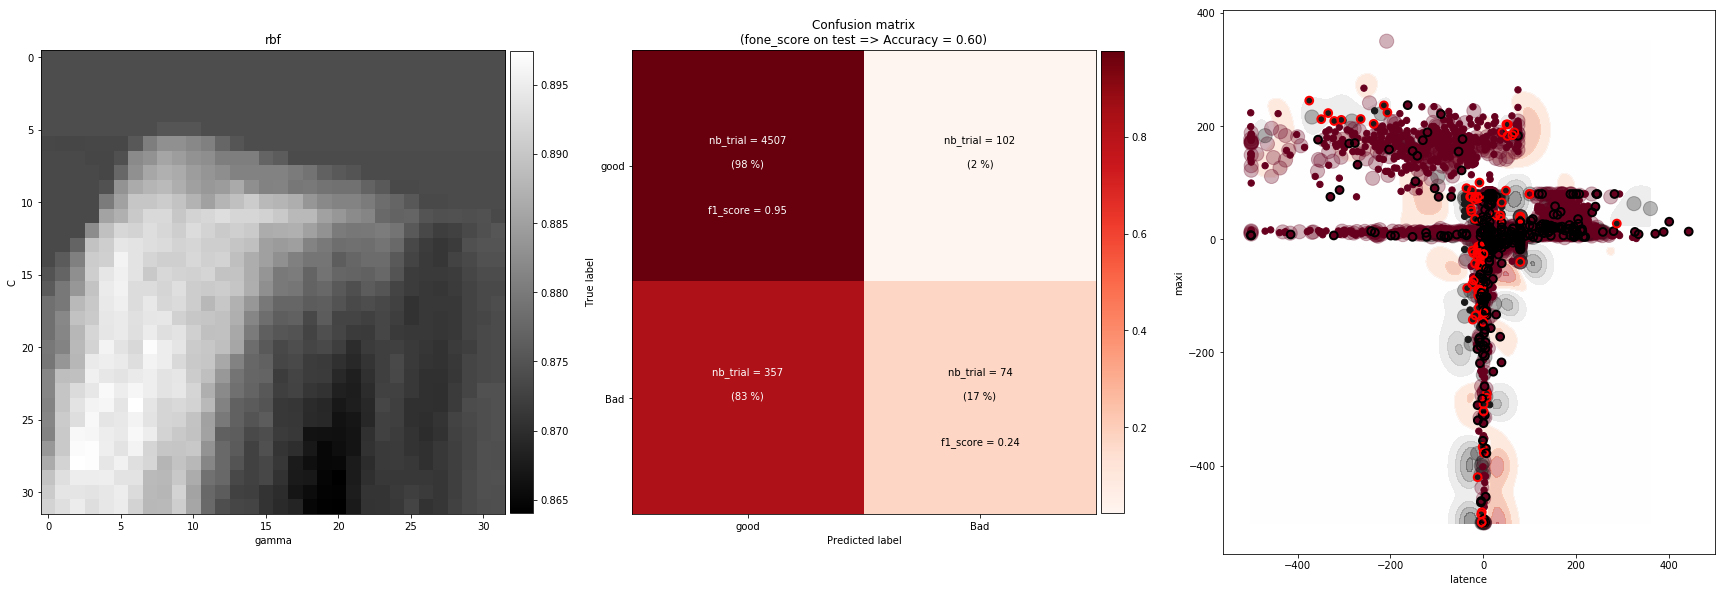

In [10]:
fig_final(X_train, y_train, X_test, y_test, var, classes) #grid, y_pred, 